# Exercise 02: Multi-class Classification 
In this exercise, you will train a deep model on the CIFAR10 from the scratch using PyTorch. The following tasks should be done:
- Task 1: per batch training/testing
- Task 2: Instance inference and visualization

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 40
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
# optimizer = optim.Adam(model.parameters())

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, output, target):
        # 计算交叉熵损失
        ce_loss = F.cross_entropy(output, target, reduction='none')

        # 计算概率
        pt = torch.exp(-ce_loss)

        # 计算Focal Loss
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # 加权Focal Loss
        if self.alpha is not None:
            assert len(self.alpha) == output.size(1), "Alpha must have the same length as the number of classes."
            alpha = self.alpha[target]
            focal_loss = focal_loss * alpha

        return focal_loss.mean()

In [9]:
##################### Write your answer here ##################
# Define the loss function

#     MAE (L1) Loss:
criterion1 = nn.L1Loss()

#     CE (Cross-Entropy) Loss
criterion2 = nn.CrossEntropyLoss()
    
#     Focal Loss (gamma=0.5)
criterion3 = FocalLoss(gamma=0.5, alpha=None)

#     Focal Loss (gamma=2)
criterion4 = FocalLoss(gamma=2, alpha=None)

###############################################################

In [10]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    output = model(image)
#     print(output)
#     print(target)
    ##################### Write your answer here ##################

#     MAE (L1) Loss:
#     loss = criterion1(output,F.one_hot(target,num_classes = 10).float())

#     CE (Cross-Entropy) Loss
#     loss = criterion2(output,target)
    
#     Focal Loss (gamma=0.5)
#     loss = criterion3(output,target)
    
#     Focal Loss (gamma=2)
    loss = criterion4(output,target)

    ###############################################################

    return output, loss

In [11]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """
    output = model(image)
    
    ##################### Write your answer here ##################
#     MAE (L1) Loss:
#     loss = criterion1(output,F.one_hot(target,num_classes = 10).float())

#     CE (Cross-Entropy) Loss
#     loss = criterion2(output,target)
                      
#     Focal Loss (gamma=0.5)
#     loss = criterion3(output,target)
    
#     Focal Loss (gamma=2)
    loss = criterion4(output,target)
    ###############################################################

    return output, loss

### Model Training

SGD

In [12]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [13]:
training_loss_SGD = []
training_acc_SGD = []
testing_loss_SGD = []
testing_acc_SGD = []
testing_loss_SGD_S = []
testing_acc_SGD_S = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_SGD.append(epoch_loss)
    training_acc_SGD.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        ## origin
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_SGD.append(val_loss)
        testing_acc_SGD.append(val_acc.cpu().detach().numpy())
        
        ## noise
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):
            image_noise = image+ torch.randn(image.size())
            image_noise = image_noise.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image_noise, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        testing_loss_SGD_S.append(val_loss)
        testing_acc_SGD_S.append(val_acc.cpu().detach().numpy())

        
        
        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/40 Train Loss: 0.0112 Acc: 0.2699
Begin test......
Test Loss: 0.0096 Acc: 0.3381
Epoch: 2/40 Train Loss: 0.0099 Acc: 0.3324
Begin test......
Test Loss: 0.0092 Acc: 0.3724
Epoch: 3/40 Train Loss: 0.0098 Acc: 0.3420
Begin test......
Test Loss: 0.0090 Acc: 0.3967
Epoch: 4/40 Train Loss: 0.0097 Acc: 0.3444
Begin test......
Test Loss: 0.0088 Acc: 0.3969
Epoch: 5/40 Train Loss: 0.0097 Acc: 0.3505
Begin test......
Test Loss: 0.0100 Acc: 0.3420
Epoch: 6/40 Train Loss: 0.0089 Acc: 0.3876
Begin test......
Test Loss: 0.0082 Acc: 0.4356
Epoch: 7/40 Train Loss: 0.0086 Acc: 0.4063
Begin test......
Test Loss: 0.0080 Acc: 0.4374
Epoch: 8/40 Train Loss: 0.0084 Acc: 0.4174
Begin test......
Test Loss: 0.0078 Acc: 0.4612
Epoch: 9/40 Train Loss: 0.0085 Acc: 0.4162
Begin test......
Test Loss: 0.0079 Acc: 0.4470
Epoch: 10/40 Train Loss: 0.0084 Acc: 0.4215
Begin test......
Test Loss: 0.0079 Acc: 0.4536
Epoch: 11/40 Train Loss: 0.0079 Acc: 0.4497
Begin test......
Test Loss: 0.0076 Acc: 0.4680
Epoch: 1

Adam

In [14]:
optimizer = optim.Adam(model.parameters())

In [15]:
training_loss_Adam = []
training_acc_Adam = []
testing_loss_Adam = []
testing_acc_Adam = []
testing_loss_Adam_S = []
testing_acc_Adam_S = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Adam.append(epoch_loss)
    training_acc_Adam.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
#     scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        # origin
        for batch_idx, (image, target) in enumerate(test_dataloader):
            
            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Adam.append(val_loss)
        testing_acc_Adam.append(val_acc.cpu().detach().numpy())
        
        # noise
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image_noise = image+ torch.randn(image.size())
            image_noise = image_noise.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image_noise, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        testing_loss_Adam_S.append(val_loss)
        testing_acc_Adam_S.append(val_acc.cpu().detach().numpy())
        

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/40 Train Loss: 0.0069 Acc: 0.5068
Begin test......
Test Loss: 0.0063 Acc: 0.5419
Epoch: 2/40 Train Loss: 0.0069 Acc: 0.5103
Begin test......
Test Loss: 0.0064 Acc: 0.5442
Epoch: 3/40 Train Loss: 0.0068 Acc: 0.5101
Begin test......
Test Loss: 0.0063 Acc: 0.5443
Epoch: 4/40 Train Loss: 0.0068 Acc: 0.5129
Begin test......
Test Loss: 0.0063 Acc: 0.5477
Epoch: 5/40 Train Loss: 0.0068 Acc: 0.5124
Begin test......
Test Loss: 0.0063 Acc: 0.5452
Epoch: 6/40 Train Loss: 0.0068 Acc: 0.5145
Begin test......
Test Loss: 0.0063 Acc: 0.5502
Epoch: 7/40 Train Loss: 0.0068 Acc: 0.5163
Begin test......
Test Loss: 0.0063 Acc: 0.5472
Epoch: 8/40 Train Loss: 0.0068 Acc: 0.5126
Begin test......
Test Loss: 0.0063 Acc: 0.5473
Epoch: 9/40 Train Loss: 0.0068 Acc: 0.5159
Begin test......
Test Loss: 0.0063 Acc: 0.5472
Epoch: 10/40 Train Loss: 0.0068 Acc: 0.5146
Begin test......
Test Loss: 0.0063 Acc: 0.5551
Epoch: 11/40 Train Loss: 0.0067 Acc: 0.5181
Begin test......
Test Loss: 0.0062 Acc: 0.5518
Epoch: 1

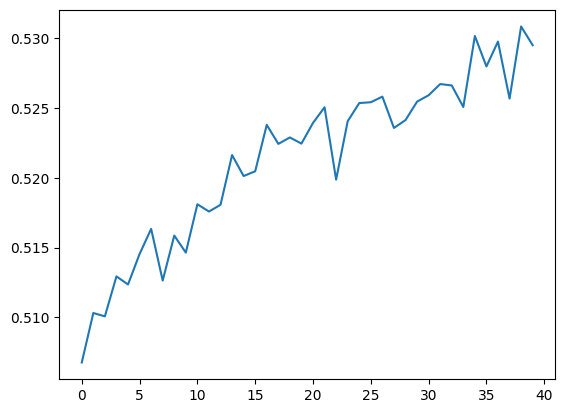

In [16]:
plt.plot(training_acc_Adam)

In [17]:
df = pd.DataFrame({
    "training_loss_SGD":training_loss_SGD,
    "training_acc_SGD":training_acc_SGD,
    "testing_loss_SGD":testing_loss_SGD,
    "testing_acc_SGD":testing_acc_SGD,
    "testing_loss_SGD_S":testing_loss_SGD_S,
    "testing_acc_SGD_S":testing_acc_SGD_S,
    "training_loss_Adam":training_loss_Adam,
    "training_acc_Adam":training_acc_Adam,
    "testing_loss_Adam":testing_loss_Adam,
    "testing_acc_Adam":testing_acc_Adam,
    "testing_loss_Adam_S":testing_loss_Adam_S,
    "testing_acc_Adam_S":testing_acc_Adam_S,
})

In [18]:
df.to_csv("Focal Loss (gamma=2).csv", index=False)  

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [19]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [20]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
input = input.to(device)
probabilities = model(input)[0]
predict_label = torch.argmax(probabilities)

print(probabilities)
print(predict_label)

tensor([-2.6790, -1.1968, -0.9805,  2.0769, -1.2767,  2.2038,  0.9790,  1.0571,
        -1.6801, -1.0561], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


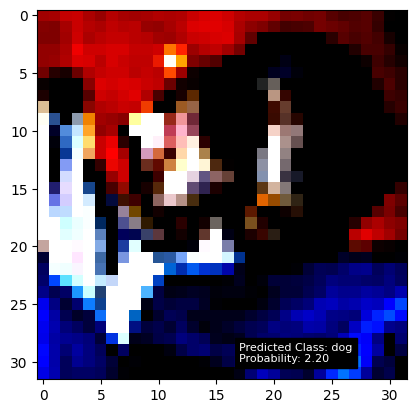

Print probabilities for each class:
airplane: -2.6790
automobile: -1.1968
bird: -0.9805
cat: 2.0769
deer: -1.2767
dog: 2.2038
frog: 0.9790
horse: 1.0571
ship: -1.6801
truck: -1.0561


In [21]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
input = input.cpu()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')